# Load Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from IPython.display import display

pd.set_option("display.max_columns",None)

# Load Dataset

In [2]:
#define dataset path
tourism_path="/content/destination.csv"
ratings_path="/content/rating.csv"
info_path="/content/tourism_info.csv"

In [3]:
tourism=pd.read_csv(tourism_path)
print(tourism.shape)
display(tourism.head())

(65, 3)


placeId                destination_name          category
0        0            Agrowisata Batulamak  wisata pertanian
1        1               Gunung Pangulubao       wisata alam
2        2  Homestay Desa wisata SIGAPITON       wisata alam
3        3      Wisata alam Goa Sigalapang       wisata alam
4        4             PUNCAK DOLOK MOTUNG       wisata alam

In [4]:
ratings=pd.read_csv(ratings_path)
print(ratings.shape)
display(ratings.head())

(10649, 3)


reviewerId  placeId  user_rating
0           0        0            5
1           1        0            5
2           2        0            5
3           3        0            5
4           4        1            5

In [5]:
#calculate n users and n items
n_users = ratings.reviewerId.unique().shape[0]
n_items = ratings.placeId.unique().shape[0]
print('Number of Reviewers = ' + str(n_users) + ' | Number of Destination = ' + str(n_items))
ratings.head()

Number of Reviewers = 8750 | Number of Destination = 65


reviewerId  placeId  user_rating
0           0        0            5
1           1        0            5
2           2        0            5
3           3        0            5
4           4        1            5

In [6]:
info=pd.read_csv(info_path)
print(info.shape)
display(info.head())

(65, 6)


placeId                                            address  \
0        0  Gurgur Aek Raja, Tampahan, Kabupaten Toba Samo...   
1        1  Jangga Toruan, Lumban Julu, Toba, North Sumatr...   
2        2  Unnamed Road, Motung, Ajibata, Kabupaten Toba ...   
3        3  Asahan, Labura, Jl. Lintas Sumatera, Meranti T...   
4        4  JW5F+H78, Horsik, Ajibata, Kabupaten Toba Samo...   

             Kecamatan  postal_code         lat          lng  
0             Tampahan        22312  23.109.321  990.258.667  
1          Lumban Julu        22312   2.597.778   99.065.278  
2              Ajibata        22386  25.996.108  989.291.808  
3  Pintu Pohan Meranti        21274  25.560.573  994.571.404  
4              Ajibata        22386      2.6089  989.231.917

In [7]:
#place rating
place_rating=pd.merge(tourism,ratings,on="placeId")
print(place_rating.shape)
display(place_rating.head())

(10649, 5)


placeId      destination_name          category  reviewerId  user_rating
0        0  Agrowisata Batulamak  wisata pertanian           0            5
1        0  Agrowisata Batulamak  wisata pertanian           1            5
2        0  Agrowisata Batulamak  wisata pertanian           2            5
3        0  Agrowisata Batulamak  wisata pertanian           3            5
4        1     Gunung Pangulubao       wisata alam           4            5

In [8]:
#check null values
display(place_rating.isnull().sum())

placeId             0
destination_name    0
category            0
reviewerId          0
user_rating         0
dtype: int64

In [9]:
place_rating_count=pd.DataFrame(place_rating.groupby('destination_name')['user_rating'].count()
             .reset_index()
             .rename(columns={'destination_name':'destination_name','user_rating':'rating_count'}))
display(place_rating_count.head())

destination_name  rating_count
0  AIR TERJUN BIDADARI JONGGI NIHUTA            10
1               Agrowisata Batulamak             4
2             Air Terjun Lumban Rang             9
3               Air Terjun Pandumaan            20
4                Air Terjun Sampuran             4

# Split dataset
80% training data, 20% testing data



In [10]:
from sklearn.model_selection import train_test_split

In [12]:
all_reviewers = place_rating['reviewerId'].unique()
print ("Number of unique reviewers in RATINGS data : ", all_reviewers.shape[0])

np.random.seed(123)
idx = np.random.rand(len(all_reviewers)) < 0.8
train_reviewers = all_reviewers[idx]
test_reviewers = all_reviewers[~idx]

df_test = place_rating[place_rating['reviewerId'].isin(test_reviewers)].reset_index(drop=True)
df_train = place_rating[place_rating['reviewerId'].isin(train_reviewers)].reset_index(drop=True)

print ("Number of unique reviewers in TEST data : ", df_test['reviewerId'].nunique())
print ("Number of unique reviewers in TRAIN data : ", df_train['reviewerId'].nunique())
print (place_rating.shape, df_test.shape, df_train.shape)

Number of unique reviewers in RATINGS data :  8750
Number of unique reviewers in TEST data :  1715
Number of unique reviewers in TRAIN data :  7035
(10649, 5) (2083, 5) (8566, 5)


In [14]:
df_train.head()

placeId      destination_name          category  reviewerId  user_rating
0        0  Agrowisata Batulamak  wisata pertanian           0            5
1        0  Agrowisata Batulamak  wisata pertanian           1            5
2        0  Agrowisata Batulamak  wisata pertanian           2            5
3        0  Agrowisata Batulamak  wisata pertanian           3            5
4        1     Gunung Pangulubao       wisata alam           4            5

In [15]:
df_test.head()

placeId            destination_name     category  reviewerId  user_rating
0        1           Gunung Pangulubao  wisata alam           6            5
1        3  Wisata alam Goa Sigalapang  wisata alam          21            5
2        3  Wisata alam Goa Sigalapang  wisata alam          37            4
3        3  Wisata alam Goa Sigalapang  wisata alam          38            5
4        3  Wisata alam Goa Sigalapang  wisata alam          44            4

--- Tambahan --

In [17]:
#masking for train data
#df_train = ratings
#for i in range(ratings_test.shape[0]):
 # df_train.loc[(df_train.reviewerId == ratings_test.iloc[[i]].reviewerId.values[0]) & (df_train.placeId == ratings_test.iloc[[i]].placeId.values[0]), 'user_rating'] = 0

In [18]:
#data training
#df_train.head()

reviewerId  placeId  user_rating
0           0        0            5
1           1        0            5
2           2        0            5
3           3        0            5
4           4        1            5

In [19]:
#make rating 0
#df_test = ratings
#for col in df_test.user_rating:
  #df_test['user_rating'].values[:] = 0

In [24]:
#masking for test data
#for i in range(ratings_test.shape[0]):
  #df_test.loc[(df_test.reviewerId == ratings_test.iloc[[i]].reviewerId.values[0]) & (df_test.placeId == ratings_test.iloc[[i]].placeId.values[0]), 'user_rating'] = ratings_test.iloc[[i]].user_rating.values[0]

In [ ]:
#data testing
#df_test.head()

reviewerId  placeId  user_rating
0           0        0            0
1           1        0            0
2           2        0            5
3           3        0            0
4           4        1            0

##TRAINING MF

In [25]:
#make matrix 
mf_train = df_train.pivot(index='reviewerId', columns='placeId', values='user_rating')
mf_train = mf_train.fillna(0)
mf_train

placeId      0    1    2    3    4    5    6    7    8    9    10   11   12  \
reviewerId                                                                    
0           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8745        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8746        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8747        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8748        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8749        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

placeId      13   14   15   16   17   18   19   20   21   22   23   24   25  \
reviewerId                                                                    
0           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8745        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8746        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8747        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8748        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8749        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

placeId      26   27   28   29   30   31   32   33   34   35   36   37   38  \
reviewerId                                                                    
0           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8745        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8746        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8747        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8748        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8749        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

placeId      39   40   41   42   43   44   45   46   47   48   49   50   51  \
reviewerId                                                                    
0           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8745        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8746        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8747        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8748        0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [26]:
#collaborative filtering process
mf_train = mf_train.to_numpy()

N = len(mf_train)
M = len(mf_train[0])

K = 8

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

user_latent_features, item_latent_features = matrix_factorization(mf_train, P, Q, K)

NameError: ignored

In [ ]:
print("The original matrix")
print(mf_train)

The original matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 4.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
train_pred = np.dot(user_latent_features, item_latent_features.T)
print("The approximation matrix by MF")
print(train_pred)

The approximation matrix by MF
[[2.64969621 3.05273019 3.21479078 ... 3.86926541 3.86216965 2.94099296]
 [3.19003878 4.1548598  3.53374565 ... 5.00704405 5.34975517 4.62314681]
 [4.93463556 5.07875558 5.7359213  ... 6.53820686 6.73379432 5.74748657]
 ...
 [3.3377758  3.68495699 4.13635256 ... 5.01915324 4.86127693 4.04267717]
 [2.63128233 1.58108459 2.88468709 ... 3.42494494 3.17671492 3.28360736]
 [3.36097823 3.03681772 3.92275589 ... 4.48324874 4.45253344 4.02964442]]


##TRAINING EVALUASI

In [ ]:
#calculate mse and rmse for training set
pred = train_pred
testset = mf_train
total = 0
jum = 0
for i in range(len(testset)):
    for j in range(len(testset[i])):
        if testset[i][j] != 0:
            total += (pred[i][j] - testset[i][j])**2
            jum += 1

mse = total / jum
print('MSE Training = ', mse)
rmse = mse**0.5
print('RMSE Training = ', rmse)

MSE Training =  0.015042093770289063
RMSE Training =  0.12264621384408514


## TRAINING MF

In [ ]:
#make matrif for testing
mf_test = df_test.pivot(index='reviewerId', columns='placeId', values='user_rating')
mf_test = mf_test.fillna(0)
mf_test

placeId      0    1    2    3    4    5    6    7    8    9    10   11   12  \
reviewerId                                                                    
0           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8745        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8746        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8747        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8748        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8749        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

placeId      13   14   15   16   17   18   19   20   21   22   23   24   25  \
reviewerId                                                                    
0           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8745        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8746        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8747        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8748        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8749        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

placeId      26   27   28   29   30   31   32   33   34   35   36   37   38  \
reviewerId                                                                    
0           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8745        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8746        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8747        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8748        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8749        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

placeId      39   40   41   42   43   44   45   46   47   48   49   50   51  \
reviewerId                                                                    
0           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
8745        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8746        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8747        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8748        0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [ ]:
#testing process

mf_test = mf_test.to_numpy()

N = len(mf_test)
M = len(mf_test[0])

K = 8

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

user_latent_features_test, item_latent_features_test = matrix_factorization(mf_test, P, Q, K)

[[0.27068388 0.3885172  0.01658687 0.29311656 0.77568476 0.16433832
  0.5018929  0.4314876  0.88227599 0.71055076 0.61684561 0.25483366
  0.6342867  0.84676712 0.01649973 0.18983972 0.08199492 0.47812033
  0.7129585  0.12244979 0.24210987 0.71031155 0.44521572 0.100009
  0.04330815 0.35691986 0.91255972 0.83356946 0.42160379 0.98200197
  0.966789   0.20331888 0.55224161 0.46831365 0.59773152 0.57519401
  0.75967639 0.42137085 0.16448566 0.47287481 0.57653408 0.05511941
  0.16125507 0.4635871  0.71222988 0.60367458 0.4770282  0.44029231
  0.35002071 0.06767123 0.22570935 0.87996874 0.95690741 0.95033265
  0.68564774 0.50540618 0.09399654 0.86731468 0.9038567  0.94030673
  0.53906746 0.91017894 0.61962211 0.86447036 0.80541701]
 [0.27102123 0.43362945 0.38297649 0.37741288 0.89735318 0.44058248
  0.16894234 0.78010798 0.4454575  0.40002659 0.44622983 0.53933346
  0.23757791 0.55625693 0.21170462 0.8922872  0.71929518 0.43756195
  0.86384378 0.45346278 0.58630759 0.18084294 0.69953719 0.6

In [ ]:
print("The original matrix")
print(mf_test)

The original matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 4.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
test_pred = np.dot(user_latent_features_test, item_latent_features_test.T)
print("The approximation matrix by MF")
print(test_pred)

The approximation matrix by MF
[[3.64266223 4.28781738 4.06400912 ... 5.71669952 5.72559637 5.05684938]
 [3.04250233 3.15361399 3.02035923 ... 4.64792371 5.0541431  4.27242482]
 [4.95556774 5.27198405 4.71755993 ... 7.42748988 6.83169581 6.24838614]
 ...
 [3.05375003 3.30587585 3.28746504 ... 4.67250977 4.71824405 4.12353594]
 [2.39455659 2.54773672 2.09573255 ... 3.60039091 3.15198935 3.20596652]
 [1.71287308 2.16210986 2.57983803 ... 2.6493939  2.93108103 2.333842  ]]


##TESTING EVALUASI

In [ ]:
#calculate testing mse and rmse
pred = test_pred
testset = mf_test
total = 0
jum = 0
for i in range(len(testset)):
    for j in range(len(testset[i])):
        if testset[i][j] != 0:
            total += (pred[i][j] - testset[i][j])**2
            jum += 1

mse = total / jum
print('MSE = ', mse)
rmse = mse**0.5
print('RMSE = ', rmse)

MSE =  0.012233688310403173
RMSE =  0.1106060048568936


##RECOMENDATION

In [ ]:
tourism_rec = []
for i in range(len(test_pred)):
  tourism_rec.append([np.argsort(-1*test_pred[i])[:20]])

In [ ]:
tourismrec = df_train.pivot(index='reviewerId', columns='placeId', values='user_rating')
tourismrec = tourismrec.fillna(0)

In [ ]:
df_tourismrec = pd.DataFrame(columns=['user','tourism_recommendation'])
for i in range(len(tourism_rec)):
  rec = []
  for j in range(len(tourism_rec[i])):
    rec.append(tourismrec.columns[tourism_rec[i][j]])  
  place = []
  for k in range(len(rec[0])):
    place.append(tourism.loc[tourism.placeId == rec[0][k]].destination_name.values[0])
  df_tourismrec.loc[i,'user'] = i
  df_tourismrec.loc[i,'tourism_recommendation'] = place

In [ ]:
df_tourismrec.loc[100].tourism_recommendation

['Pantai Lumban Bul-bul Balige',
 'Taman Eden 100',
 'Air Terjun Situmurun',
 'BUKIT GIBEON (YAPIM TARUNA)',
 'Pantai Parparean 2',
 'Pantai Pasir Putih Parparean',
 'Air Terjun Sigura-Gura',
 'Pemandian Bukit Gibeon',
 'Siregar Aek Nalas',
 'Bukit Senyum',
 'Museum Batak Tb Silalahi Center',
 'Tarabunga',
 'Monumen Raja SONAKMALELA',
 'The Kaldera',
 'Pantai Tambunan Sunset Beach',
 'wisata BUKIT GIBEON SIBISA PARAPAT',
 'Desa Adat Ragi Hotang Meat',
 'Tugu Pahlawan Revolusi',
 'Singgolom',
 'Air Terjun Siboruon']

--batasan---

In [ ]:
#if we want to recommend movie based on rating, we want rating count 

place_rating_combine=pd.merge(place_rating,place_rating_count,left_on='destination_name',right_on='destination_name',how='left')
print(place_rating_combine.shape)
display(place_rating_combine.head())

(10649, 6)


placeId      destination_name          category  reviewerId  user_rating  \
0        0  Agrowisata Batulamak  wisata pertanian           0            5   
1        0  Agrowisata Batulamak  wisata pertanian           1            5   
2        0  Agrowisata Batulamak  wisata pertanian           2            5   
3        0  Agrowisata Batulamak  wisata pertanian           3            5   
4        1     Gunung Pangulubao       wisata alam           4            5   

   rating_count  
0             4  
1             4  
2             4  
3             4  
4             3

In [ ]:
display(place_rating_combine.describe())

placeId    reviewerId   user_rating  rating_count
count  10649.000000  10649.000000  10649.000000  10649.000000
mean      49.938586   3959.584374      4.410837   1197.092027
std       12.991053   2572.977696      0.996594   1003.453600
min        0.000000      0.000000      1.000000      1.000000
25%       47.000000   1628.000000      4.000000    239.000000
50%       56.000000   3780.000000      5.000000   1029.000000
75%       58.000000   6150.000000      5.000000   1815.000000
max       64.000000   8749.000000      5.000000   2633.000000

Threshold value help us to filter the movies based on rating_count that mean we can't say that a movie with 1 rating of 5 is top movie so we need no. of ratings/rating count

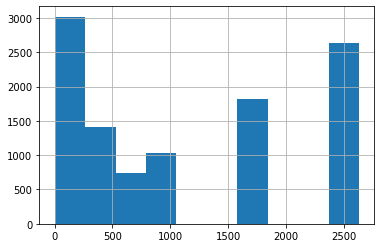

In [ ]:
#plot histogram of rating_count to find threshold value
place_rating_combine['rating_count'].hist()

#### Hence from histogram we can say that threshold value will be 50 
We won't consider that movie who's rating is 5 but by the one-two users so we will take threshold value of rating count of movies

In [ ]:
rating_threshold=50

#return dataframe with rating_count>=50
place_rating_popular=place_rating_combine[place_rating_combine['rating_count']>=rating_threshold]
print(place_rating_popular.shape)

(10157, 6)


Text(0.5, 1.0, 'Top Rates Place')

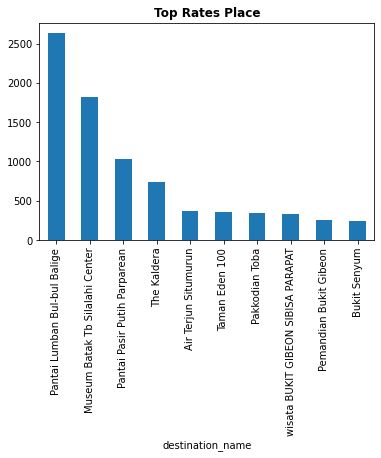

In [ ]:
#top rated movies based on rating counts

place_rating_popular.groupby('destination_name').mean().sort_values('rating_count',ascending=False).head(10)['rating_count'].plot.bar()
plt.title("Top Rates Place",weight='bold')

# Nearest Neighbor item based Collaborative Filtering

In [17]:
#create a Pivot matrix
place_users_rating=df_train.pivot(index='destination_name',columns='reviewerId',values='user_rating').fillna(0)
place_users_rating = place_users_rating.fillna(0)
place_users_rating
#print(place_users_rating.shape)
#display(place_users_rating.head())

reviewerId                          0     1     2     3     4     5     7     \
destination_name                                                               
AIR TERJUN BIDADARI JONGGI NIHUTA    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Agrowisata Batulamak                 5.0   5.0   5.0   5.0   0.0   0.0   0.0   
Air Terjun Lumban Rang               0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Pandumaan                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Sampuran                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                                  ...   ...   ...   ...   ...   ...   ...   
pasir Putih Porsea                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata BUKIT GIBEON SIBISA PARAPAT   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata PUNCAK PANGKODIAN             0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata Rumah Pohon                   0.0   0.0   5.0   0.0   0.0   0.0   0.0   
wisata alam Ajibata                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   

reviewerId                          8     9     10    11    12    13    14    \
destination_name                                                               
AIR TERJUN BIDADARI JONGGI NIHUTA    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Agrowisata Batulamak                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Lumban Rang               0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Pandumaan                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Sampuran                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                                  ...   ...   ...   ...   ...   ...   ...   
pasir Putih Porsea                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata BUKIT GIBEON SIBISA PARAPAT   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata PUNCAK PANGKODIAN             0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata Rumah Pohon                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata alam Ajibata                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   

reviewerId                          15    16    17    18    19    20    22    \
destination_name                                                               
AIR TERJUN BIDADARI JONGGI NIHUTA    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Agrowisata Batulamak                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Lumban Rang               0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Pandumaan                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Sampuran                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                                  ...   ...   ...   ...   ...   ...   ...   
pasir Putih Porsea                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata BUKIT GIBEON SIBISA PARAPAT   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata PUNCAK PANGKODIAN             0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata Rumah Pohon                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata alam Ajibata                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   

reviewerId                          23    24    25    26    27    28    29    \
destination_name                                                               
AIR TERJUN BIDADARI JONGGI NIHUTA    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Agrowisata Batulamak                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Lumban Rang               0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Pandumaan                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Sampuran                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                                  ...   ...   ...   ...   ...   ...   ...   
pasir Putih Porsea                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata BUKIT GIBEON SIBISA PARAPAT   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata PUNCAK PANGKODIAN             0.0   0.0   0.0   0.0   0.0   0.0   0.0 

In [18]:
print("The original matrix")
print(place_users_rating)

Streaming output truncated to the last 5000 lines.

reviewerId                          5649  5650  5651  5654  5656  5657  5658  \
destination_name                                                               
AIR TERJUN BIDADARI JONGGI NIHUTA    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Agrowisata Batulamak                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Lumban Rang               0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Pandumaan                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Air Terjun Sampuran                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                                  ...   ...   ...   ...   ...   ...   ...   
pasir Putih Porsea                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata BUKIT GIBEON SIBISA PARAPAT   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata PUNCAK PANGKODIAN             0.0   0.0   0.0   0.0   0.0   0.0   0.0   
wisata Rumah Pohon                   0.0   0.0   0.0   0.0   0.0   0

In [19]:
from scipy.sparse import csr_matrix
place_users_rating_matrix=csr_matrix(place_users_rating.values)

In [20]:
from sklearn.neighbors import NearestNeighbors
knn=NearestNeighbors(metric='cosine',algorithm='brute')
knn.fit(place_users_rating)

NearestNeighbors(algorithm='brute', metric='cosine')

In [21]:
#define index i.e which place I visit and based on this, more place will be recommended
random_index=np.random.choice(place_users_rating.shape[0])

#define place index for next algo
recommendation_for=place_users_rating.index[random_index]

print("{}[Index={}]".format(place_users_rating.index[random_index],random_index))
print(recommendation_for)

pasir Putih Porsea[Index=60]
pasir Putih Porsea


In [22]:
#get top k recommended place
topk=5

#return cosine distance with index of recommended place
distance,indices=knn.kneighbors(place_users_rating.iloc[random_index,:].values.reshape(1,-1),n_neighbors=5)

#print
display(distance,indices)

array([[0.        , 0.95329966, 0.95648691, 0.96563937, 0.97246148]])

array([[60, 38,  7, 44, 26]])

# Correlation

If a user watch above then which movies will be recommended to user?

In [30]:
df_train.head(6)

placeId      destination_name          category  reviewerId  user_rating
0        0  Agrowisata Batulamak  wisata pertanian           0            5
1        0  Agrowisata Batulamak  wisata pertanian           1            5
2        0  Agrowisata Batulamak  wisata pertanian           2            5
3        0  Agrowisata Batulamak  wisata pertanian           3            5
4        1     Gunung Pangulubao       wisata alam           4            5
5        1     Gunung Pangulubao       wisata alam           5            5

In [31]:
#create pivot table
#columns are destination_name because we want to find corr of movie with other movie
users_place_rating=df_train.pivot_table(index='reviewerId',columns='destination_name',values='user_rating').fillna(0)

display(users_place_rating.head())

destination_name  AIR TERJUN BIDADARI JONGGI NIHUTA  Agrowisata Batulamak  \
reviewerId                                                                  
0                                               0.0                   5.0   
1                                               0.0                   5.0   
2                                               0.0                   5.0   
3                                               0.0                   5.0   
4                                               0.0                   0.0   

destination_name  Air Terjun Lumban Rang  Air Terjun Pandumaan  \
reviewerId                                                       
0                                    0.0                   0.0   
1                                    0.0                   0.0   
2                                    0.0                   0.0   
3                                    0.0                   0.0   
4                                    0.0                   0.0   

destination_name  Air Terjun Sampuran  Air Terjun Sampuran Harimau  \
reviewerId                                                           
0                                 0.0                          0.0   
1                                 0.0                          0.0   
2                                 0.0                          0.0   
3                                 0.0                          0.0   
4                                 0.0                          0.0   

destination_name  Air Terjun Sialogo  Air Terjun Siboruon  \
reviewerId                                                  
0                                0.0                  0.0   
1                                0.0                  0.0   
2                                0.0                  0.0   
3                                0.0                  0.0   
4                                0.0                  0.0   

destination_name  Air Terjun Sigura-Gura  Air Terjun Situmurun  \
reviewerId                                                       
0                                    0.0                   0.0   
1                                    0.0                   0.0   
2                                    0.0                   0.0   
3                                    0.0                   0.0   
4                                    0.0                   0.0   

destination_name  Air Terjun Taman Eden 100  BUKIT GIBEON (YAPIM TARUNA)  \
reviewerId                                                                 
0                                       0.0                          0.0   
1                                       0.0                          0.0   
2                                       0.0                          0.0   
3                                       0.0                          0.0   
4                                       0.0                          0.0   

destination_name  Batu Basiha  Bukit Dolok Tolong  Bukit Pahoda  Bukit Senyum  \
reviewerId                                                                      
0                         0.0                 0.0           0.0           0.0   
1                         0.0                 0.0           0.0           0.0   
2                         0.0                 0.0           0.0           0.0   
3                         0.0                 0.0           0.0           0.0   
4                         0.0                 0.0           0.0           0.0   

destination_name  Bukit Senyum Motung  \
reviewerId                              
0                                 0.0   
1                                 0.0   
2                                 0.0   
3                                 0.0   
4                                 0.0   

destination_name  Caldera toba nomadic escape (glamour camping)  \
reviewerId                                                        
0                                                           0.0   
1                        

In [32]:
print(recommendation_for)

pasir Putih Porsea


In [33]:
#rating of above movie to find the corr of this with others
recommendation_for_rating=users_place_rating[recommendation_for]
display(recommendation_for_rating)

reviewerId
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8744    0.0
8746    0.0
8747    0.0
8748    0.0
8749    0.0
Name: pasir Putih Porsea, Length: 7035, dtype: float64

In [35]:
# corr of users rating for "given movie" with all other movies
similar_to_recommendation=users_place_rating.corrwith(recommendation_for_rating)
similar_to_recommendation.head()

destination_name
AIR TERJUN BIDADARI JONGGI NIHUTA   -0.001742
Agrowisata Batulamak                -0.001455
Air Terjun Lumban Rang              -0.001920
Air Terjun Pandumaan                -0.002443
Air Terjun Sampuran                 -0.001260
dtype: float64

In [37]:
#creating a dataframe 
similar_to_recommendation=pd.DataFrame(similar_to_recommendation,columns=['Correlation'])
similar_to_recommendation.dropna(inplace=True)

display(similar_to_recommendation.head())

Correlation
destination_name                              
AIR TERJUN BIDADARI JONGGI NIHUTA    -0.001742
Agrowisata Batulamak                 -0.001455
Air Terjun Lumban Rang               -0.001920
Air Terjun Pandumaan                 -0.002443
Air Terjun Sampuran                  -0.001260

In [92]:
#sorting by Correlation to find which has highest correlation
similar_to_recommendation=similar_to_recommendation.sort_values('Correlation',ascending=False)

#first place will not be considered because we want to recommend based on that only
display(similar_to_recommendation.head(5))

Correlation
destination_name                         
pasir Putih Porsea               1.000000
Air Terjun Siboruon              0.039979
Rest Area Adian Nalambok         0.029702
Pantai Pasir Putih Parparean     0.028207
Monumen Raja SONAKMALELA         0.021654

In [93]:
destination_sorted=similar_to_recommendation.sort_values('Correlation',ascending=False)
display(destination_sorted.head(10))

Correlation
destination_name                         
pasir Putih Porsea               1.000000
Air Terjun Siboruon              0.039979
Rest Area Adian Nalambok         0.029702
Pantai Pasir Putih Parparean     0.028207
Monumen Raja SONAKMALELA         0.021654
Air Terjun Taman Eden 100        0.021279
Siregar Aek Nalas                0.018843
Air Terjun Sigura-Gura           0.017564
Tugu Pahlawan Revolusi           0.016058
Long Beach                       0.013016

In [98]:
df_cf=pd.merge(tourism, destination_sorted, on='destination_name')
print(df_cf.shape)
display(df_cf.head(65))

(65, 4)


placeId                destination_name          category  Correlation
0         0            Agrowisata Batulamak  wisata pertanian    -0.001455
1         1               Gunung Pangulubao       wisata alam    -0.001029
2         2  Homestay Desa wisata SIGAPITON       wisata alam    -0.001029
3         3      Wisata alam Goa Sigalapang       wisata alam    -0.005496
4         4             PUNCAK DOLOK MOTUNG       wisata alam    -0.000727
..      ...                             ...               ...          ...
60       60              Pantai Janji Maria     wisata bahari    -0.004946
61       61                  Hatulian Beach     wisata bahari     0.011349
62       62          Air Terjun Sigura-Gura       wisata alam     0.017564
63       63        Monumen Raja SONAKMALELA    wisata sejarah     0.021654
64       64     Air Terjun Sampuran Harimau       wisata alam    -0.003458

[65 rows x 4 columns]

# Result

In [97]:
print("Recommandetions for {}:".format(recommendation_for))
for i,val in enumerate(similar_to_recommendation.head(5).index.values[1:],1):
    print("{}) {}".format(i,val))

Recommandetions for pasir Putih Porsea:
1) Air Terjun Siboruon
2) Rest Area Adian Nalambok
3) Pantai Pasir Putih Parparean
4) Monumen Raja SONAKMALELA


#CBF

In [70]:
tourism.head()

placeId                destination_name          category
0        0            Agrowisata Batulamak  wisata pertanian
1        1               Gunung Pangulubao       wisata alam
2        2  Homestay Desa wisata SIGAPITON       wisata alam
3        3      Wisata alam Goa Sigalapang       wisata alam
4        4             PUNCAK DOLOK MOTUNG       wisata alam

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [72]:
#tf-idf untuk kolom related
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(tourism['category'])

In [73]:
#from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity
cosine_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_similarity_matrix

array([[1.        , 0.12860453, 0.12860453, ..., 0.12860453, 0.0670374 ,
        0.12860453],
       [0.12860453, 1.        , 1.        , ..., 1.        , 0.15291302,
        1.        ],
       [0.12860453, 1.        , 1.        , ..., 1.        , 0.15291302,
        1.        ],
       ...,
       [0.12860453, 1.        , 1.        , ..., 1.        , 0.15291302,
        1.        ],
       [0.0670374 , 0.15291302, 0.15291302, ..., 0.15291302, 1.        ,
        0.15291302],
       [0.12860453, 1.        , 1.        , ..., 1.        , 0.15291302,
        1.        ]])

In [74]:
# Reverse mapping of indices# Reverse mapping of indices and movie titles
indices = pd.Series(tourism.index, index=tourism['destination_name'])
display(indices)

destination_name
Agrowisata Batulamak               0
Gunung Pangulubao                  1
Homestay Desa wisata SIGAPITON     2
Wisata alam Goa Sigalapang         3
PUNCAK DOLOK MOTUNG                4
                                  ..
Pantai Janji Maria                60
Hatulian Beach                    61
Air Terjun Sigura-Gura            62
Monumen Raja SONAKMALELA          63
Air Terjun Sampuran Harimau       64
Length: 65, dtype: int64

In [126]:
print(indices['pasir Putih Porsea'])

16


In [76]:
list(enumerate(cosine_similarity_matrix[indices['Air Terjun Sampuran Harimau']]))

[(0, 0.12860452827044108),
 (1, 1.0000000000000002),
 (2, 1.0000000000000002),
 (3, 1.0000000000000002),
 (4, 1.0000000000000002),
 (5, 1.0000000000000002),
 (6, 0.13772383470733496),
 (7, 0.12860452827044108),
 (8, 0.13772383470733496),
 (9, 0.5226560803221355),
 (10, 0.13772383470733496),
 (11, 1.0000000000000002),
 (12, 1.0000000000000002),
 (13, 1.0000000000000002),
 (14, 1.0000000000000002),
 (15, 1.0000000000000002),
 (16, 0.20243471597302679),
 (17, 0.1457034869406688),
 (18, 1.0000000000000002),
 (19, 0.1457034869406688),
 (20, 1.0000000000000002),
 (21, 1.0000000000000002),
 (22, 0.20243471597302679),
 (23, 1.0000000000000002),
 (24, 0.20243471597302679),
 (25, 0.1529130244319049),
 (26, 1.0000000000000002),
 (27, 1.0000000000000002),
 (28, 1.0000000000000002),
 (29, 1.0000000000000002),
 (30, 0.20243471597302679),
 (31, 0.1529130244319049),
 (32, 1.0000000000000002),
 (33, 1.0000000000000002),
 (34, 0.1457034869406688),
 (35, 0.20243471597302679),
 (36, 1.0000000000000002),
 

In [127]:
def give_recommendation(destination_name,k, cosine_similarity_matrix=cosine_similarity_matrix):
    
    # Get the index corresponding to original_title
    idx = indices[destination_name]

    # Get the pairwsie similarity scores 
    cosine_similarity_scores = list(enumerate(cosine_similarity_matrix[idx]))

    # Sort the movies 
    cosine_similarity_scores = sorted(cosine_similarity_scores, key=lambda x: x[1], reverse=True)

    # Scores of the top k most similar movies
    cosine_similarity_scores = cosine_similarity_scores[1:k+1]

    # Movie indices
    movie_indices = [i[0] for i in cosine_similarity_scores]
    
    # Movie indices
    movie_similarity = [i[1] for i in cosine_similarity_scores]

    # Movie titles
    movie_titles=tourism['destination_name'].iloc[movie_indices].values
        
    # Top k most similar movies
    return pd.DataFrame({'destination_name':movie_titles,'cosine':movie_similarity})

In [129]:
# Testing our content-based recommendation system with the "Toy Story (1995)"
df_cbf=give_recommendation('pasir Putih Porsea',10)
display(df_cbf)

destination_name  cosine
0             Simananduk Motung     1.0
1                    Long Beach     1.0
2                Pakkodian Toba     1.0
3            Pantai Parparean 2     1.0
4  Pantai Tambunan Sunset Beach     1.0
5     PASIR PUTIH LUMBAN BULBUL     1.0
6                   Pantai Meat     1.0
7             Siregar Aek Nalas     1.0
8          Pantai Sibola Hotang     1.0
9  Pantai Lumban Bul-bul Balige     1.0

In [130]:
destination="pasir Putih Porsea"
topk=10

print("Recommanded Destination for {} are:".format(destination))

for i,val in enumerate(df['destination_name'].values):
    print("{}) {}".format(i+1,val))

Recommanded Destination for pasir Putih Porsea are:
1) Homestay Desa wisata SIGAPITON
2) Wisata alam Goa Sigalapang
3) PUNCAK DOLOK MOTUNG
4) wisata alam Ajibata
5) Air Terjun Sialogo
6) Air Terjun Lumban Rang
7) Caldera toba nomadic escape (glamour camping)
8) AIR TERJUN BIDADARI JONGGI NIHUTA
9) Siboruon Waterfall
10) Bukit Dolok Tolong


In [132]:
destination_place=pd.merge(df_cf, df_cbf, on='destination_name')
print(destination_place.shape)
display(destination_place.head(65))

(10, 5)


placeId              destination_name       category  Correlation  cosine
0       22             Simananduk Motung  wisata bahari    -0.001260     1.0
1       24                    Long Beach  wisata bahari     0.013016     1.0
2       30                Pakkodian Toba  wisata bahari    -0.005765     1.0
3       35            Pantai Parparean 2  wisata bahari     0.001837     1.0
4       37  Pantai Tambunan Sunset Beach  wisata bahari    -0.006204     1.0
5       43     PASIR PUTIH LUMBAN BULBUL  wisata bahari    -0.008080     1.0
6       45                   Pantai Meat  wisata bahari    -0.002039     1.0
7       49             Siregar Aek Nalas  wisata bahari     0.018843     1.0
8       52          Pantai Sibola Hotang  wisata bahari    -0.005597     1.0
9       56  Pantai Lumban Bul-bul Balige  wisata bahari    -0.025621     1.0

#HYBRID

In [133]:
from sklearn.preprocessing import MinMaxScaler
scale=MinMaxScaler()
transformed=scale.fit_transform(destination_place[['Correlation',	'cosine']])
transformed

array([[0.54787561, 0.        ],
       [0.86894196, 0.        ],
       [0.44656901, 0.        ],
       [0.61752112, 0.        ],
       [0.43669096, 0.        ],
       [0.39448399, 0.        ],
       [0.53036293, 0.        ],
       [1.        , 0.        ],
       [0.45033616, 0.        ],
       [0.        , 0.        ]])

In [134]:
destination_place[['Correlation_norm','cosine_norm']]=transformed

In [135]:
display(destination_place[['Correlation_norm','cosine_norm']].head())

Correlation_norm  cosine_norm
0          0.547876          0.0
1          0.868942          0.0
2          0.446569          0.0
3          0.617521          0.0
4          0.436691          0.0

In [136]:
score=destination_place['Correlation_norm']*0.5+destination_place['cosine_norm']*0.5
destination_place['score']=score
destination_place_sorted=destination_place.sort_values('score',ascending=False)

In [137]:
display(destination_place_sorted[['placeId','destination_name','category','Correlation','cosine','score']].head())

placeId    destination_name       category  Correlation  cosine     score
7       49   Siregar Aek Nalas  wisata bahari     0.018843     1.0  0.500000
1       24          Long Beach  wisata bahari     0.013016     1.0  0.434471
3       35  Pantai Parparean 2  wisata bahari     0.001837     1.0  0.308761
0       22   Simananduk Motung  wisata bahari    -0.001260     1.0  0.273938
6       45         Pantai Meat  wisata bahari    -0.002039     1.0  0.265181